In [1]:
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("SDEsim.jl")
using .SDEsim, Plots

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


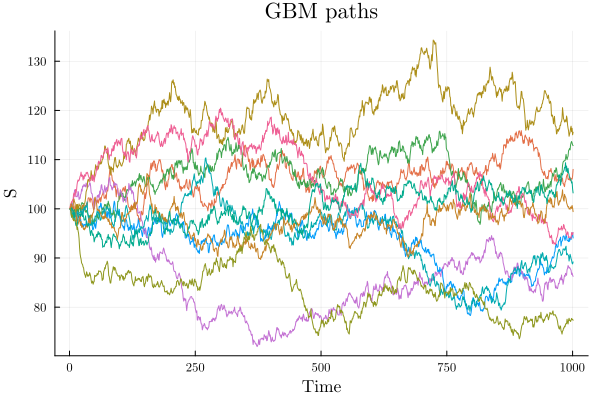

In [4]:
# Problem parameters
T = 1.0
N = 1000
M = 10
σ  = 0.2
S0 = 100.0
f(x, t) = 0.0                # drift under risk-neutral measure
g(x, t) = σ*x                # GBM noise term (dS = σS dW)
paths = simulate_paths(f, g, S0; T, N, M)
plot(paths, title="GBM paths", xlabel="Time", ylabel="S", legend=false, fontfamily="Computer Modern")